# The [AES](https://en.wikipedia.org/wiki/Advanced_Encryption_Standard) cipher
Consist of 4 steps:
1. Sub byte 
2. Shift Rows
3. Mix Columns
4. Add Round key
All steps applied one by one, on the same data makes the AES cipher, secure. Depending on key length, multiple rounds of said transformation steps are applied on the same data block. The goal of this notebook is to implement all 4 steps independently. And than test implementation of AES algorithm against [crypto](https://pycryptodome.readthedocs.io/en/latest/src/cipher/aes.html) library.

In [101]:
import numpy as nn
from numpy import uint8
from typing import List
import math
from dataclasses import dataclass

In [102]:
AES_SBOX = (
            0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
            0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
            0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
            0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
            0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
            0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
            0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
            0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
            0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
            0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
            0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
            0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
            0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
            0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
            0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
            0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
            )
AES_SVBOX_INV = (
            0x52, 0x09, 0x6A, 0xD5, 0x30, 0x36, 0xA5, 0x38, 0xBF, 0x40, 0xA3, 0x9E, 0x81, 0xF3, 0xD7, 0xFB,
            0x7C, 0xE3, 0x39, 0x82, 0x9B, 0x2F, 0xFF, 0x87, 0x34, 0x8E, 0x43, 0x44, 0xC4, 0xDE, 0xE9, 0xCB,
            0x54, 0x7B, 0x94, 0x32, 0xA6, 0xC2, 0x23, 0x3D, 0xEE, 0x4C, 0x95, 0x0B, 0x42, 0xFA, 0xC3, 0x4E,
            0x08, 0x2E, 0xA1, 0x66, 0x28, 0xD9, 0x24, 0xB2, 0x76, 0x5B, 0xA2, 0x49, 0x6D, 0x8B, 0xD1, 0x25,
            0x72, 0xF8, 0xF6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xD4, 0xA4, 0x5C, 0xCC, 0x5D, 0x65, 0xB6, 0x92,
            0x6C, 0x70, 0x48, 0x50, 0xFD, 0xED, 0xB9, 0xDA, 0x5E, 0x15, 0x46, 0x57, 0xA7, 0x8D, 0x9D, 0x84,
            0x90, 0xD8, 0xAB, 0x00, 0x8C, 0xBC, 0xD3, 0x0A, 0xF7, 0xE4, 0x58, 0x05, 0xB8, 0xB3, 0x45, 0x06,
            0xD0, 0x2C, 0x1E, 0x8F, 0xCA, 0x3F, 0x0F, 0x02, 0xC1, 0xAF, 0xBD, 0x03, 0x01, 0x13, 0x8A, 0x6B,
            0x3A, 0x91, 0x11, 0x41, 0x4F, 0x67, 0xDC, 0xEA, 0x97, 0xF2, 0xCF, 0xCE, 0xF0, 0xB4, 0xE6, 0x73,
            0x96, 0xAC, 0x74, 0x22, 0xE7, 0xAD, 0x35, 0x85, 0xE2, 0xF9, 0x37, 0xE8, 0x1C, 0x75, 0xDF, 0x6E,
            0x47, 0xF1, 0x1A, 0x71, 0x1D, 0x29, 0xC5, 0x89, 0x6F, 0xB7, 0x62, 0x0E, 0xAA, 0x18, 0xBE, 0x1B,
            0xFC, 0x56, 0x3E, 0x4B, 0xC6, 0xD2, 0x79, 0x20, 0x9A, 0xDB, 0xC0, 0xFE, 0x78, 0xCD, 0x5A, 0xF4,
            0x1F, 0xDD, 0xA8, 0x33, 0x88, 0x07, 0xC7, 0x31, 0xB1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xEC, 0x5F,
            0x60, 0x51, 0x7F, 0xA9, 0x19, 0xB5, 0x4A, 0x0D, 0x2D, 0xE5, 0x7A, 0x9F, 0x93, 0xC9, 0x9C, 0xEF,
            0xA0, 0xE0, 0x3B, 0x4D, 0xAE, 0x2A, 0xF5, 0xB0, 0xC8, 0xEB, 0xBB, 0x3C, 0x83, 0x53, 0x99, 0x61,
            0x17, 0x2B, 0x04, 0x7E, 0xBA, 0x77, 0xD6, 0x26, 0xE1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0C, 0x7D
            )

In [103]:
# Sub byte

def sub_bytes(data_block:List[uint8])->List[uint8]:
        
        for i, b in enumerate(data_block):
            data_block[i] = AES_SBOX[b]
            
        return data_block
    
def inv_sub_bytes(data_block:List[uint8])->List[uint8]:
        for i, b in enumerate(data_block):
            data_block[i] = AES_SVBOX_INV[b]
        return data_block

In [104]:

bytes = [uint8(32),
         uint8(64),
         uint8(16),
         uint8(8)]
print(sub_bytes(bytes.copy()))
print(inv_sub_bytes(sub_bytes(bytes.copy())))

[183, 9, 202, 48]
[32, 64, 16, 8]


In [105]:
def shift_rows(data_block:List[uint8])->List[uint8]:
    if len(data_block) != 128:
        print("provided data_block is incorrect size, using ")
    rows = []
    no_shifts = math.ceil(math.sqrt(len(data_block)))
    for r in range( math.ceil(len(data_block) / no_shifts) ):
        if r + 1< math.ceil(len(data_block) / no_shifts) :
            rows.append(data_block[r*no_shifts : (r+1)*no_shifts])
        else :
            rows.append(data_block[r*no_shifts :])



    data_block = []
    for i,row in enumerate(rows):
        if len(row) == no_shifts:
            data_block += row[i:] + row[:i]
        else:
            data_block += row
    return data_block

def inv_shift_rows(data_block:List[uint8])->List[uint8]:
    if len(data_block) != 128:
        print("provided data_block is incorrect size, using ")
    rows = []
    no_shifts = math.ceil(math.sqrt(len(data_block)))
    for r in range( math.ceil(len(data_block) / no_shifts) ):
        if r + 1< math.ceil(len(data_block) / no_shifts) :
            rows.append(data_block[r*no_shifts : (r+1)*no_shifts])
        else :
            rows.append(data_block[r*no_shifts :])



    data_block = []
    for i,row in enumerate(rows):
        if len(row) == no_shifts:
            data_block +=  row[no_shifts - i:] + row[:no_shifts - i] 
        else:
            data_block += row
    return data_block


In [106]:
bytes = [uint8(32),
         uint8(64),
         uint8(16),
         uint8(8),
         uint8(5),
         uint8(4),
         uint8(3)]
print(math.ceil(math.sqrt(len(bytes))))
print(shift_rows(bytes.copy()))
print(inv_shift_rows(shift_rows(bytes.copy())))

3
provided data_block is incorrect size, using 
[32, 64, 16, 5, 4, 8, 3]
provided data_block is incorrect size, using 
provided data_block is incorrect size, using 
[32, 64, 16, 8, 5, 4, 3]


In [107]:
@staticmethod
def g_mul(a:uint8, b:uint8):
    p = 0
    for _ in range(8):
        if b & 1:
            p ^= a
        a <<= 1
        if a & 0x100:
            a ^= 0x11b
        b >>= 1
    return p
    
def mix_columns(self):
        ss = []
        for c in range(4):
            col = self.state[c*4:(c+1)*4]
            ss.extend((
                        g_mul([0x02][col[0]]) ^ g_mul([0x03][col[1]]) ^                col[2]  ^                col[3] ,
                                       col[0]  ^ g_mul([0x02][col[1]]) ^ g_mul([0x03][col[2]]) ^                col[3] ,
                                       col[0]  ^                col[1]  ^ g_mul([0x02][col[2]]) ^ g_mul([0x03][col[3]]),
                        g_mul([0x03][col[0]]) ^                col[1]  ^                col[2]  ^ g_mul([0x02][col[3]]),
                    ))
        self.state = ss

In [108]:

def add_round_key(data_block:List[uint8], key:List[uint8])->List[uint8]:
    # if not isinstance(data_block, List[uint8]):
    #     raise TypeError(f"given data_block with incorrect type, expected List[uint8] got {type(data_block)} ")
    
    # if not isinstance(key, List[uint8]):
    #     raise TypeError(f"given key with incorrect type, expected List[uint8] got {type(key)} ")
    
    if len(key) != len(data_block):
        raise ValueError("key length must mach data block length")
    
    for i,k in enumerate(key):
        data_block[i] ^= k
    return data_block


In [109]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [110]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1=nn.Linear(8,8*4)
        self.fc2=nn.Linear(8*4,8*4)
        self.fc3=nn.Linear(8*4,8)
        
    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.sigmoid(x)
        return output
net = Net()
    

In [111]:
def bytes_to_float_array(data_block:List[uint8])->List[float]:
    result : List[float] = []
    
    for id, byte in enumerate(data_block):
        input = bin(byte)
        input = input[2:]
        input = input[::-1]
        for _ in range(8):
            result.append(0.0)

        for i, bit in enumerate(input):
            result[id * 8 + i] = float(bit)
            
    return result
print(bytes_to_float_array({uint8(6)}))

[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [112]:
import random
@dataclass()
class CryptoDataset:
    key: List[uint8] 
    size: int # no of bytes in ciphered message
    # original_message : List[uint8]
    # ciphered_message : List[uint8]
    @staticmethod
    def from_size(size:int):
        copy_key = []
        
        for _ in range(size) :
            copy_key.append(uint8(random.randint(0,255)))
        return CryptoDataset(size=size,key = copy_key)
        
    def __init__(self,size:int,key:List[uint8] ):
        self.size = size
        self.key = key
    
    def next(self):
        
        label : List[uint8] = []
        for _ in range(self.size) :
            label.append(uint8(random.randint(0,255)))
        
         
        input : List[uint8] = add_round_key(label,self.key) 
        return (bytes_to_float_array(input),bytes_to_float_array(label))
        
    

In [113]:
def loss_function(output:List[float],label:List[float]):

    same = 0
    for o, l in zip(output,label):
        if o == l:
            same+=1
        
    return torch.tensor(1 - (same / len(input)), requires_grad=True)

In [114]:
import torch.optim as optim

criterion = nn.L1Loss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

[1,   100] loss: 0.024
[2,   100] loss: 0.024
[3,   100] loss: 0.024
[4,   100] loss: 0.024
[5,   100] loss: 0.024
[6,   100] loss: 0.024
[7,   100] loss: 0.024
[8,   100] loss: 0.024
[9,   100] loss: 0.024
[10,   100] loss: 0.024
[11,   100] loss: 0.024
[12,   100] loss: 0.024
[13,   100] loss: 0.024
[14,   100] loss: 0.024
[15,   100] loss: 0.023
[16,   100] loss: 0.023
[17,   100] loss: 0.023
[18,   100] loss: 0.023
[19,   100] loss: 0.023
[20,   100] loss: 0.023
[21,   100] loss: 0.023
[22,   100] loss: 0.023
[23,   100] loss: 0.023
[24,   100] loss: 0.023
[25,   100] loss: 0.023
[26,   100] loss: 0.023
[27,   100] loss: 0.022
[28,   100] loss: 0.022
[29,   100] loss: 0.023
[30,   100] loss: 0.023


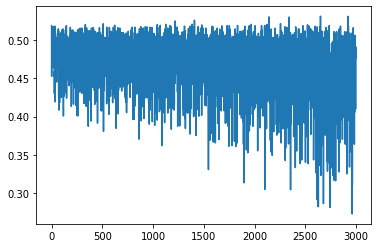

In [120]:

dataloader = CryptoDataset.from_size(1)
lr = []
for epoch in range(30):  # loop over the dataset multiple times
    running_loss = 0.0
    for iteration in range(100):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels  = dataloader.next() # torch.tensor([float(i)]) / 100, torch.tensor([float(i+10)]) / 100

        # inputs, labels  = inputs/ -256, labels.reshape(-1, 0) / -256

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(torch.FloatTensor(inputs))
        loss = criterion(outputs, torch.FloatTensor(labels))
        loss.backward()
        optimizer.step()
 
        # print statistics
        running_loss += loss.item()
        lr.append(loss.item())
        if iteration % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {iteration + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
plt.plot(lr)
            